In [1]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Users/arda/GitHub/RadLab/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# Step 1: Load and structure data
df = pd.read_csv("data/ilr_transformed_full_data.csv")

## K-means (first try)

In [13]:
# Step 2: Preprocess each participant’s data into a time series format
# Group by ID to collect each participant’s time series data
# Structure each participant's data as a list of [ilr1, ilr2, ilr3, excluded, injustice, personal, violence]

time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    # Sort by 'time' to ensure the sequence is in order
    group_sorted = group.sort_values("time")
    
    # Extract relevant variables (including control variables) as a list of lists
    time_series = group_sorted[['ilr1', 'ilr2', 'ilr3', 'excluded', 'injustice', 'personal', 'violence', 'Experiment']].values
    
    # Normalize lengths by padding or truncating to the max time length if necessary (for equal lengths)
    max_length = 15  # Adjust this as appropriate for your dataset
    if len(time_series) < max_length:
        # Pad with NaNs or some other value to standardize length
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        # Truncate if longer
        time_series = time_series[:max_length]
    
    # Append to the list
    time_series_data.append(time_series)
    
# Convert to numpy array for tslearn (ignoring NaNs in DTW, or filling them if necessary)
time_series_data = np.array(time_series_data)

# Step 3: Scale the data
# Scaling each feature within each time series
scaled_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

# Step 4: Perform DTW KMeans clustering
n_clusters = 4  # Adjust this number based on desired cluster count
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)

# Cluster the time series data
labels = model.fit_predict(scaled_data)

# Add labels to original data for analysis
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

# Now, `labels` has the cluster assignments for each participant.
# You can analyze each cluster’s characteristics, trends, or visualize them.

# Count the number of participants in each cluster
cluster_counts = df["cluster"].value_counts()
print(cluster_counts)

# Summary statistics for each cluster (e.g., average ilr values, control variables)
cluster_summary = df.groupby("cluster")[["ilr1", "ilr2", "ilr3", "excluded", "injustice", "personal", "violence"]].mean()
print(cluster_summary)

cluster
0    6004
3    5529
1    4705
2    3400
Name: count, dtype: int64
             ilr1      ilr2      ilr3  excluded  injustice  personal  violence
cluster                                                                       
0        0.801778  2.312204 -0.537418  4.084658   4.389597  3.999167  1.632840
1        1.309502  1.938793 -1.065987  4.314073   4.392280  4.214855  1.501981
2        1.303192  2.205549 -0.864857  4.189286   4.392857  4.164286  1.521429
3        0.679840  2.083189 -0.646520  4.100380   4.406073  4.005736  1.661053


In [6]:
import numpy as np
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

# Step 1: Normalize by Experiment and Time Point
# Group by Experiment and time, then normalize each feature within these groups
normalized_df = df.copy()
features_to_normalize = ['ilr1', 'ilr2', 'ilr3', 'excluded', 'injustice', 'personal', 'violence']

for feature in features_to_normalize:
    normalized_df[feature] = normalized_df.groupby(['Experiment', 'time'])[feature].transform(lambda x: (x - x.mean()) / x.std())

# Step 2: Preprocess each participant’s data into a time series format
# Group by ID to collect each participant’s normalized time series data
time_series_data = []
grouped = normalized_df.groupby("ID")

for participant, group in grouped:
    # Sort by 'time' to ensure the sequence is in order
    group_sorted = group.sort_values("time")
    
    # Extract relevant normalized variables (excluding 'Experiment')
    time_series = group_sorted[features_to_normalize].values
    
    # Normalize lengths by padding or truncating to the max time length if necessary (for equal lengths)
    max_length = 15  # Adjust this as appropriate for your dataset
    if len(time_series) < max_length:
        # Pad with NaNs or some other value to standardize length
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        # Truncate if longer
        time_series = time_series[:max_length]
    
    # Append to the list
    time_series_data.append(time_series)
    
# Convert to numpy array for tslearn (ignoring NaNs in DTW, or filling them if necessary)
time_series_data = np.array(time_series_data)

# Step 3: Scale the data
# Scaling each feature within each time series
scaled_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

# Step 4: Perform DTW KMeans clustering
n_clusters = 3  # Adjust this number based on desired cluster count
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)

# Cluster the time series data
labels = model.fit_predict(scaled_data)

# Add labels to original data for analysis
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

# Now, `labels` has the cluster assignments for each participant.
# You can analyze each cluster’s characteristics, trends, or visualize them.

# Count the number of participants in each cluster
cluster_counts = df["cluster"].value_counts()
print(cluster_counts)

# Summary statistics for each cluster (e.g., average ilr values, control variables)
cluster_summary = df.groupby("cluster")[features_to_normalize].mean()
print(cluster_summary)


cluster
0    19638
Name: count, dtype: int64
             ilr1      ilr2      ilr3  excluded  injustice  personal  violence
cluster                                                                       
0        0.975902  2.139796 -0.751464  4.162164   4.395443   4.08128  1.590142


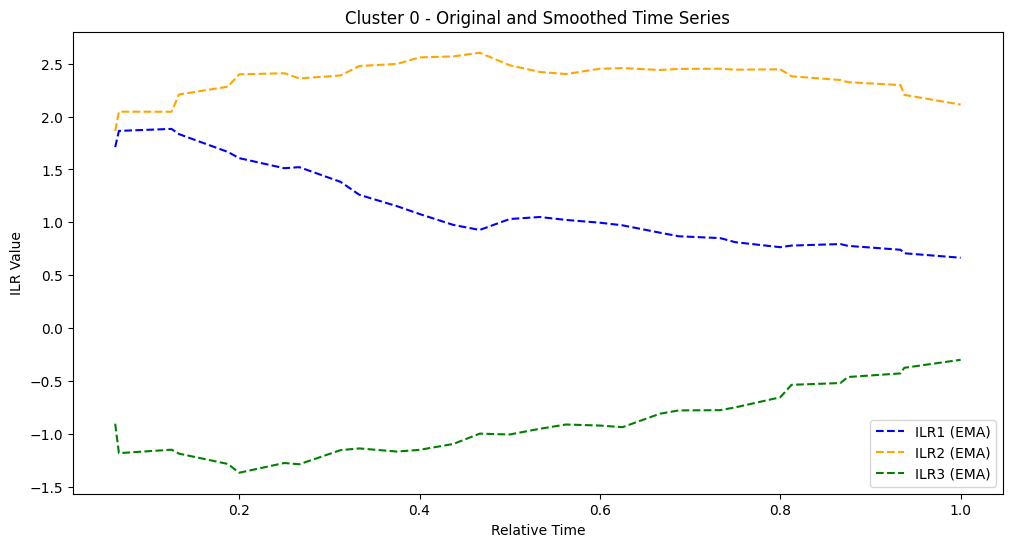

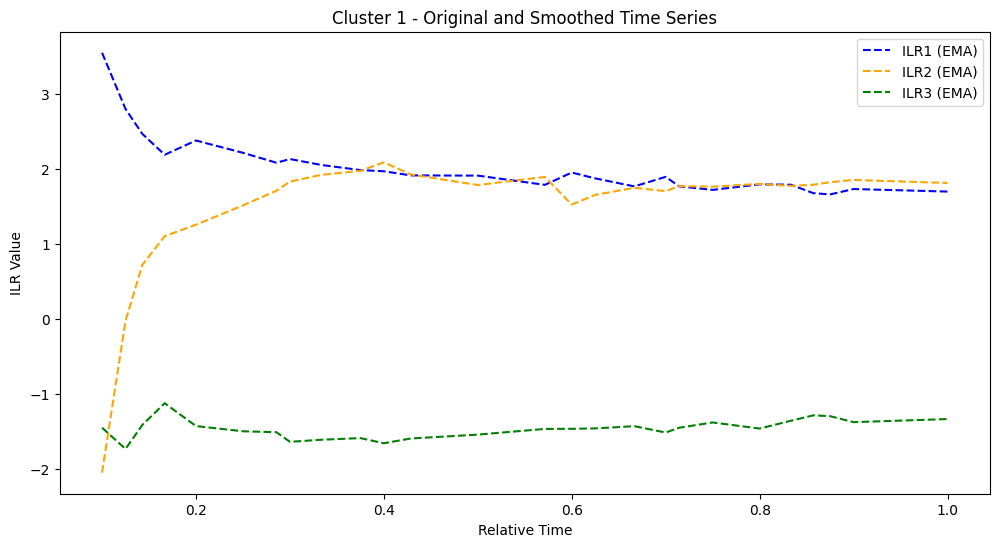

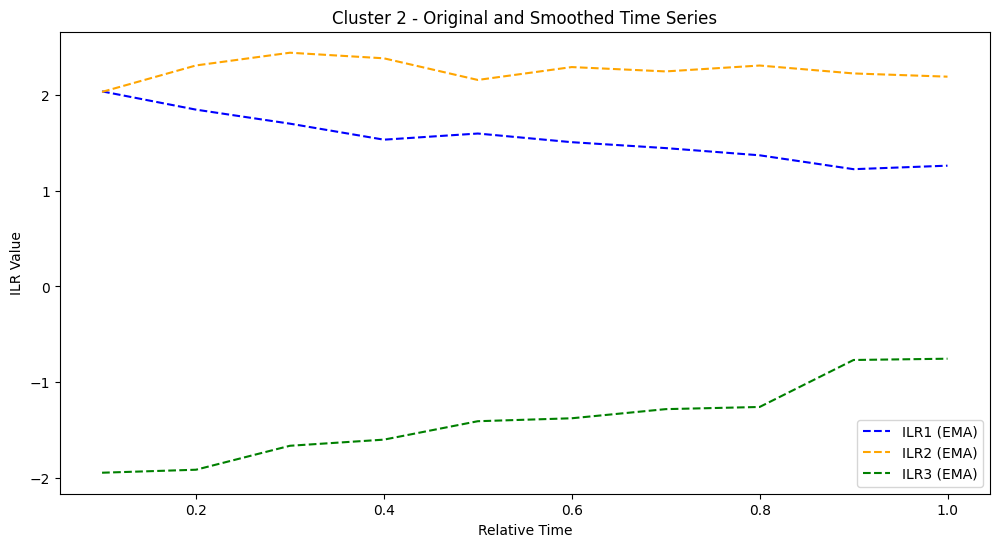

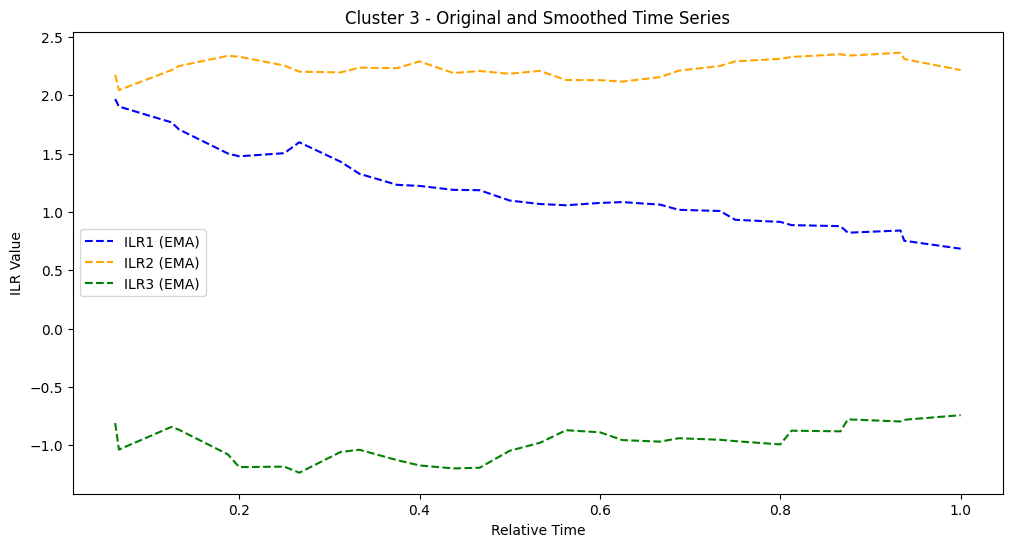

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Assuming 'df' contains your data and is already prepared with 'relative_time' and cluster labels
# Creating a relative time variable for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Define the number of clusters (adjust to the actual number of clusters)
n_clusters = 4  # Example

# Smoothing parameters
alpha = 0.05  # Smoothing factor for EMA
savgol_window = 5  # Window length for Savitzky-Golay filter
savgol_polyorder = 2  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # Group by relative time and calculate the mean of ilr variables
    mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Apply Savitzky-Golay Filter smoothing
    mean_ilr_smooth_savgol = pd.DataFrame({
        "ilr1": savgol_filter(mean_relative["ilr1"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr2": savgol_filter(mean_relative["ilr2"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr3": savgol_filter(mean_relative["ilr3"], window_length=savgol_window, polyorder=savgol_polyorder)
    }, index=mean_relative.index)

    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")


    # Plot Savitzky-Golay smoothed series
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr1"], label="ILR1 (Savitzky-Golay)", linestyle="-.", color="blue")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr2"], label="ILR2 (Savitzky-Golay)", linestyle="-.", color="orange")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr3"], label="ILR3 (Savitzky-Golay)", linestyle="-.", color="green")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("ILR Value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()

## Hierarchical with Normalizing per Experiment

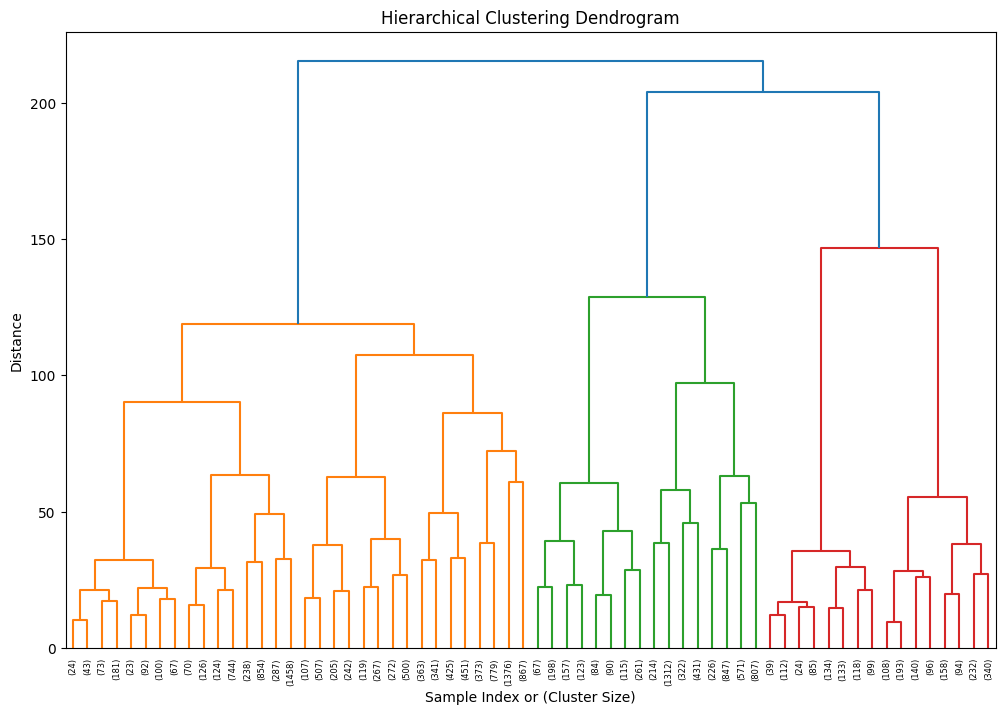

In [40]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load your data
# df = pd.read_csv('your_data.csv')  # Replace with your actual data loading line if needed

# Step 1: Normalize DVs (ilr1, ilr2, ilr3) by Experiment
def normalize_by_experiment(df, dv_columns, group_column):
    """
    Normalize specified columns within groups defined by group_column.
    """
    normalized_df = df.copy()
    for col in dv_columns:
        # Normalize each DV column within each experiment
        normalized_df[col] = df.groupby(group_column)[col].transform(lambda x: (x - x.mean()) / x.std())
    return normalized_df

# Columns to normalize
dv_columns = ['ilr1', 'ilr2', 'ilr3']
df_normalized = normalize_by_experiment(df, dv_columns, 'Experiment')

# Step 2: Prepare Data for Clustering
clustering_data = df_normalized[dv_columns + ['excluded', 'injustice', 'personal', 'violence', 'Experiment']]

# Step 3: Standardize the Data for Clustering
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Step 3.1: Check for any NaNs or Infinite values and replace them with 0
# This can prevent non-finite values from causing errors in the linkage function
clustering_data_scaled = np.nan_to_num(clustering_data_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Step 4: Perform Hierarchical Clustering
# Compute the linkage matrix
linkage_matrix = linkage(clustering_data_scaled, method='ward')

# Plot the dendrogram to inspect cluster distances
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()